## Feature Engineering

In [14]:
import pandas as pd
import numpy as np

# Load the data
covid_data = pd.read_csv('filtered_datasets/cases_state.csv', parse_dates=['date'])
hospital_data = pd.read_csv('filtered_datasets/hospital.csv', parse_dates=['date'])

# Merge the data on the date column
data = pd.merge(covid_data, hospital_data, on=['date', 'state'])

# Sort the data by date
data = data.sort_values(by='date')

# Create lag features
def create_lag_features(data, lag=14):
    for i in range(1, lag + 1):
        data[f'cases_new_lag_{i}'] = data['cases_new'].shift(i)
    return data

# Apply the function to create lag features
data = create_lag_features(data)

# Drop rows with missing values (due to lagging)
data = data.dropna()

# Select the features and target
features = [col for col in data.columns if 'cases_new_lag' in col]
target = 'admitted_covid'


## Data Preparation

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Split the data into training and testing sets
X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## Model Training


In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Initialize the random forest regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

## Prediction and Evaluation

In [24]:
# List of states
states = data['state'].unique()

# Dictionary to store results for each state
results = {}

for state in states:
    # Filter data for the current state
    state_data = data[data['state'] == state]
    
    # Split the data into training and testing sets
    X = state_data[features]
    y = state_data[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Initialize the random forest regressor
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    print(f'State: {state}')
    print(f'Mean Absolute Error: {mae}')
    print(f'Mean Squared Error: {mse}')
    print(f'Root Mean Squared Error: {rmse}\n')
    
    # Store results
    results[state] = {
        'model': model,
        'scaler': scaler,
        'mae': mae,
        'mse': mse,
        'rmse': rmse
    }

State: Perlis
Mean Absolute Error: 1.5531045751633987
Mean Squared Error: 7.407805555555554
Root Mean Squared Error: 2.7217284132616086

State: Pulau Pinang
Mean Absolute Error: 5.1061764705882355
Mean Squared Error: 97.77824673202613
Root Mean Squared Error: 9.888288362099182

State: W.P. Labuan
Mean Absolute Error: 0.8631475409836066
Mean Squared Error: 2.893105573770492
Root Mean Squared Error: 1.7009131587975006

State: W.P. Kuala Lumpur
Mean Absolute Error: 14.712091503267972
Mean Squared Error: 1003.4103431372549
Root Mean Squared Error: 31.676652966139823

State: Terengganu
Mean Absolute Error: 3.5177124183006536
Mean Squared Error: 32.374648366013076
Root Mean Squared Error: 5.689872438465828

State: Selangor
Mean Absolute Error: 23.486514161220043
Mean Squared Error: 2560.8880365286855
Root Mean Squared Error: 50.605217483266344

State: Sabah
Mean Absolute Error: 13.047189542483661
Mean Squared Error: 456.3108150326798
Root Mean Squared Error: 21.36143288809718

State: Sarawak

## Plot actual vs predicted values


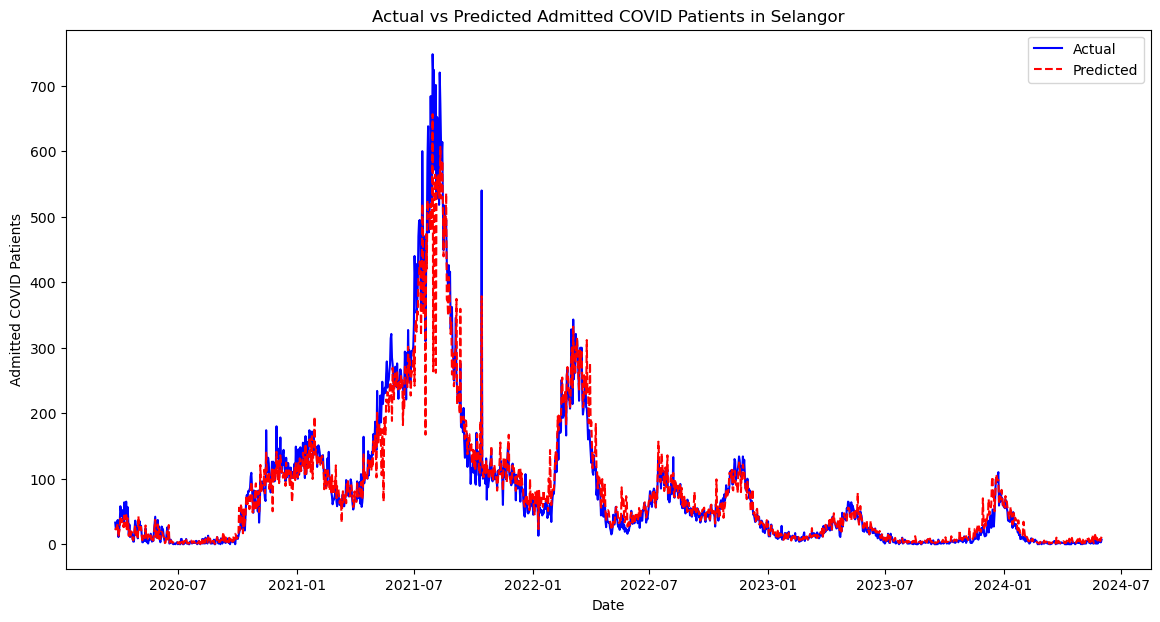

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization: Actual vs Predicted values for a specific state
state_to_plot = 'Selangor'
state_data = data[data['state'] == state_to_plot]
X = state_data[features]
y = state_data[target]

# Scale the features using the scaler from the state's model
scaler = results[state_to_plot]['scaler']
X_scaled = scaler.transform(X)

# Predict using the model for the specific state
model = results[state_to_plot]['model']
y_pred_all = model.predict(X_scaled)

# Combine the actual and predicted values into a single DataFrame for easier plotting
plot_data = pd.DataFrame({
    'date': state_data['date'],
    'actual': y,
    'predicted': y_pred_all
})

plt.figure(figsize=(14, 7))
plt.plot(plot_data['date'], plot_data['actual'], label='Actual', color='blue')
plt.plot(plot_data['date'], plot_data['predicted'], label='Predicted', color='red', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Admitted COVID Patients')
plt.title(f'Actual vs Predicted Admitted COVID Patients in {state_to_plot}')
plt.legend()
plt.show()